---

## FIN5622 Project 4: *Stock Price Prediction by Using RNN-LSTM Model*


Please use [Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb) to implement your work and refer to this [Vedio on Youtube](https://www.youtube.com/watch?v=QIUxPv5PJOY) and in-class coding example. 

---

<div class = "alert alert-block alert-danger">
    <b>Due Date</b>: April 17, 2021, 11:59PM EST
</div> 

<div class = "panel panel-success">
    <div class = "panel-heading"> 
    <span style="color:black"><b>Project Introduction</b>
    </div>
    <div class = "panel-body"> 
    In this project, we will use Recursive Neural Network (RNN) Long Short Term Memory (LSTM) model to predict stock prices by using previous <code>n_sample</code> days' prece data for S&P100 over the period from 2012-01-01 to 2019-12-31.  
    </div>
</div>
<div class = "panel panel-info">
    <div class = "panel-heading"> 
    <span style="color:black"><b>Instructions</b>
    </div>
    <div class = "panel-body"> 
    Please code you solutions directly in this Notebook under each task in the cells provided below. Tasks are intended to be done in order with results from one task informing work in later tasks. Include all code used to produce your results, and support your answers with textual explanations if neccessary. You may feel free to add additional Code and/or Markdown cells as needed. Code must be written using <b>Python 3</b>.
    <br><br>Please order the cells in your Notebook in the order in which they are intended to run! It is expected that your Notebook is able to run in sequence from start to finish without any errors (before submitting check by: <code>Kernel > Restart & Run All</code>).
    <br><br>Once ready, please submit your assignment as an <b>.ipynb file</b> (<code>File > Download as > Notebook</code>). You must name your files in the following format: <b><code>FIN5622_Project_4_Your-Name.ipynb</code></b>.
    </div>
</div>

---
<div class = "alert alert-block alert-warning">
    <b>Note</b>: Import all libraries that you plan on using in the code block below.
</div>

In [3]:
# import packages
import pandas_datareader as web
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)


<div class = "panel panel-primary">
    <div class = "panel-heading"> 
    <span style="color:white"><b>Task 1: Load Data</b>
    </div>
    <br>
    <div class = "panel-body"> 
    Load the "SPY" price dataset from Yahoo using the pandas <code>DataReader</code> function and store it in a dataframe called <code>stock_prices</code>. The dataset contains daily stock price over the period from 2012-01-01 to 2019-12-31. 
    <br><br>
    Check that the shape of <code>stock_prices</code> is <code>(2012, 6)</code>, where each row represent a different date and each column represents a different type of prices.
    <br><br>
    Visualize the history of prices by ploting <code>stock_prices['Close']</code>
    <p style="text-align:right;">[20pts]</p>
    </div>
</div>

In [4]:
# get historical stock prices
stock_prices = web.DataReader('SPY', data_source = 'yahoo', start = '2012-01-01', end = '2019-12-31')
stock_prices

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,128.380005,127.430000,127.760002,127.500000,193697900.0,106.331924
2012-01-04,127.809998,126.709999,127.199997,127.699997,127186500.0,106.498711
2012-01-05,128.229996,126.430000,127.010002,128.039993,173895000.0,106.782272
2012-01-06,128.220001,127.290001,128.199997,127.709999,148050000.0,106.507057
2012-01-09,128.179993,127.410004,128.000000,128.020004,99530200.0,106.765602
...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,314.311646
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,315.984802
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,315.906494


In [5]:
stock_prices.shape

(2012, 6)

In [6]:
stock_prices['Close']

Date
2012-01-03    127.500000
2012-01-04    127.699997
2012-01-05    128.039993
2012-01-06    127.709999
2012-01-09    128.020004
                 ...    
2019-12-24    321.230011
2019-12-26    322.940002
2019-12-27    322.859985
2019-12-30    321.079987
2019-12-31    321.859985
Name: Close, Length: 2012, dtype: float64

<div class = "panel panel-primary">
    <div class = "panel-heading"> 
    <span style="color:white"><b>Task 2: Preprocess Data</b>
    </div>
    <br>
    <div class = "panel-body"> 
    Pick only "Close" price as the independent variable and convert it to the numpy array. 
    <br><br>
    Choose the first 80% daily prices as training dataset and the rest of data as a testing dataset. 
    <br><br>
    Use <code>MinMaxScaler(feature_range=(0,1))</code> to scale the training data. 
    <br><br>
        At each date point of the training dataset (start from <code>n_sample = 100</code>), use previous <code>n_sample = 100</code> daily price data as feature variables and the current daily price as the target variable to create a training dataset for the training of a RNN-LSTM model. 
    <BR><BR>
    Reshape the data for LSTM model as a 3D numpy array by <code>x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))</code>.
    <br><br>
    Check the size of the training input data for the model, it should be <code> (1510,100,1)</code>.
    <p style="text-align:right;">[20pts]</p>
    </div>
</div>

In [7]:
close_prices = stock_prices.filter(['Close'])
close_values = close_prices.values
close_values

array([[127.5       ],
       [127.69999695],
       [128.03999329],
       ...,
       [322.85998535],
       [321.07998657],
       [321.85998535]])

In [8]:
train_size = math.ceil(len(close_values)*0.8)
# create train dataset 
train_data = close_values[:train_size]

In [9]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_data)
scaled_data = scaler.transform(close_values)
train_data = scaled_data[0:train_size,:]

In [10]:
# split traininng data into x and y
x_train = []
y_train = []

# use previous 100 days 
for i in range(100, train_size):
  x_train.append(train_data[i-100:i,0])
  y_train.append(train_data[i,0])
  
# convert x_train and y_train to np.array
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data for LSTM model as a 3D numpy array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
x_train.shape

(1510, 100, 1)

<div class = "panel panel-primary">
    <div class = "panel-heading"> 
    <span style="color:white"><b>Task 3: Build Model</b>
    </div>
    <br>
    <div class = "panel-body"> 
    Build a sequential model with two LSTM layers and two Dense layers. Each LSTM layer has 50 nodes. The first Dense layer has 25 nodes and the last one has one node.  
    <br><br>
    Compile the model by using <code>model.compile(optimizer='adam', loss='mean_squared_error')</code>. 
    <br><br>
    Use <code>MinMaxScaler(feature_range=(0,1))</code> to scale the training data. 
    <br><br>
        Train your model by using hyperparameters: <code>batch_size=32</code> and <code>epochs=20</code>.
    <p style="text-align:right;">[20pts]</p>
    </div>
</div>

In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(x_train, y_train, batch_size=32, epochs=12)

Epoch 1/12
48/48 [==============================] - 8s 89ms/step - loss: 0.0568
Epoch 2/12
48/48 [==============================] - 5s 98ms/step - loss: 6.3012e-04
Epoch 3/12
48/48 [==============================] - 5s 100ms/step - loss: 4.9246e-04
Epoch 4/12
48/48 [==============================] - 5s 98ms/step - loss: 4.6302e-04
Epoch 5/12
48/48 [==============================] - 5s 99ms/step - loss: 4.2375e-04
Epoch 6/12
48/48 [==============================] - 5s 100ms/step - loss: 5.7781e-04
Epoch 7/12
48/48 [==============================] - 5s 100ms/step - loss: 3.6069e-04
Epoch 8/12
48/48 [==============================] - 5s 100ms/step - loss: 4.5711e-04
Epoch 9/12
48/48 [==============================] - 5s 104ms/step - loss: 4.1746e-04
Epoch 10/12
48/48 [==============================] - 5s 110ms/step - loss: 3.9746e-04
Epoch 11/12
48/48 [==============================] - 5s 100ms/step - loss: 4.4025e-04
Epoch 12/12
48/48 [==============================] - 5s 101ms/step - lo

<div class = "panel panel-primary">
    <div class = "panel-heading"> 
    <span style="color:white"><b>Task 4: Test Model</b>
    </div>
    <br>
    <div class = "panel-body"> 
    Create a testing dataset that can be used to test the trained model. 
    <br><br>
    Use the trained model to predict the testing data and convert it back to the original scale by <code>scaler.inverse_transform(y_pred_test)</code>. 
    <br><br>
    Calculate the error (RMSE) by <code>mean_squared_error(y_pred_test, y_test, squared=False)</code>. 
    <p style="text-align:right;">[20pts]</p>
    </div>
</div>

In [22]:
# create the test dataset
test_data = scaled_data[train_size - 100:,:]
# create x_test and y_test
x_test = []
y_test = close_values[train_size:,:]
test_size = len(test_data)
for i in range(100, test_size):
  x_test.append(test_data[i-100:i, 0])

# convert x_test to np.array
x_test = np.array(x_test)
# reshape x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(402, 100, 1)

In [23]:
# get the prediction values
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# calculate rmse
rmse = mean_squared_error(y_pred, y_test, squared=False)
rmse

5.189971090747935

<div class = "panel panel-primary">
    <div class = "panel-heading"> 
    <span style="color:white"><b>Task 5: Present Model</b>
    </div>
    <br>
    <div class = "panel-body"> 
    Plot the last 100 "Close Price" in the training dataset. 
    <br><br>
    Plot the "Close Price" in the testing dataset. 
    <br><br>
    Plot the model predicted "Close Price" of the testing dataset.
    <br><br>
    Calculate and plot the difference between returns of close prices and returns of predicted close prices in the testing dataset.
    <BR><BR>
    Calculate and print the percentage of misclassified return data (return of the close price and return of predicted close price has different sign at the same date) in the testing dataset.
    <p style="text-align:right;">[20pts]</p>
    </div>
</div>

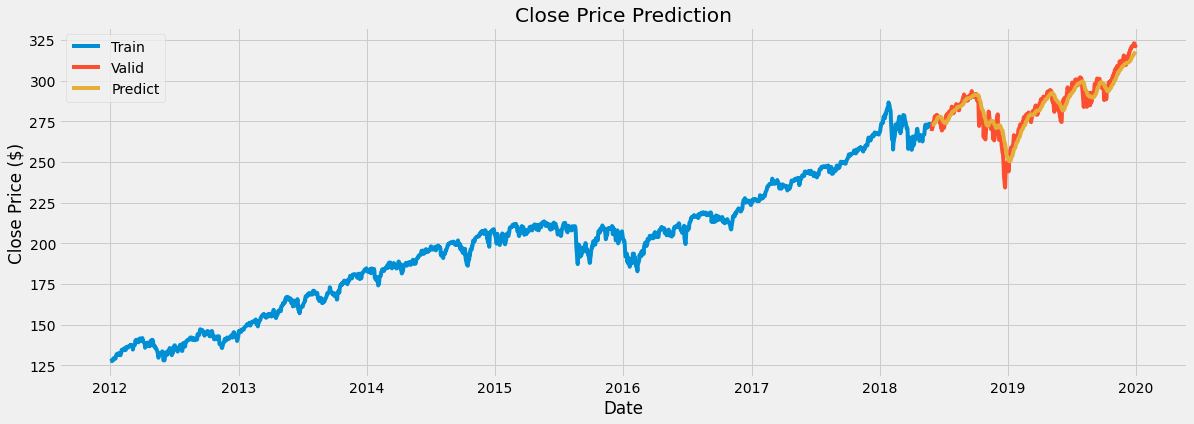

In [26]:
# plot data
train = close_prices[:train_size].copy()
valid = close_prices[train_size:].copy()
valid['Prediction'] = y_pred
plt.figure(figsize=(18,6))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Close Price Prediction')
plt.legend(['Train', 'Valid', 'Predict'])
plt.show()

<function ndarray.sort>